## PART B

#### Math Model

In [36]:
import numpy as np
import pandas as pd

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return float(np.mean((y_true - y_pred) ** 2))

def r2_variance(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    R^2 = 1 - MSE / Variance(observed)
    """
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    var_obs = np.var(y_true)
    if var_obs == 0:
        return 0.0
    return float(1.0 - mse(y_true, y_pred) / var_obs)

def gradient_descent(X: np.ndarray, y: np.ndarray, lr: float, iters: int, record_every: int, w0: np.ndarray | None = None, b0: float | None = None,) -> tuple[np.ndarray, float, list[float]]:
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1)

    n, p = X.shape
    w = np.zeros(p, dtype=float) if w0 is None else np.asarray(w0, dtype=float).reshape(p)
    b = 0.0 if b0 is None else float(b0)

    losses = []
    for t in range(1, iters + 1):
        y_hat = X @ w + b
        err = y_hat - y

        grad_w = (2.0 / n) * (X.T @ err)
        grad_b = (2.0 / n) * np.sum(err)

        w -= lr * grad_w
        b -= lr * grad_b

        if record_every and (t % record_every == 0 or t == 1 or t == iters):
            losses.append(float(np.mean(err ** 2)))

    return w, b, losses

def predict(X: np.ndarray, w: np.ndarray, b: float) -> np.ndarray:
    X = np.asarray(X, dtype=float)
    return X @ w + b


#### Train/Test split + preprocessing

In [37]:

def load_and_split(csv_path: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(csv_path)

    test_df = df.iloc[500:630].copy()
    train_df = pd.concat([df.iloc[:500], df.iloc[630:]], axis=0).copy()

    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)

    return train_df, test_df

def get_Xy(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, list[str], str]:
    target_candidates = [c for c in df.columns if "compressive strength" in c.lower()]
    target_col = target_candidates[0]
    feature_cols = [c for c in df.columns if c != target_col]

    X = df[feature_cols].to_numpy(dtype=float)
    y = df[target_col].to_numpy(dtype=float)
    return X, y, feature_cols, target_col

def Normal_transform(X_train: np.ndarray, X_test: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X_train = np.asarray(X_train, dtype=float)
    X_test = np.asarray(X_test, dtype=float)

    x_min = X_train.min(axis=0)
    x_max = X_train.max(axis=0)
    denom = (x_max - x_min)
    denom_safe = np.where(denom == 0, 1.0, denom)

    X_train_mm = (X_train - x_min) / denom_safe
    X_test_mm = (X_test - x_min) / denom_safe
    return X_train_mm, X_test_mm

#### Experiments and Record results

In [38]:

def run_univariate(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, feature_cols: list[str], scaled_label: str, grid: list[dict], record_every: int,) -> pd.DataFrame:
    rows = []
    n_features = X_train.shape[1]

    for j in range(n_features):
        xtr = X_train[:, [j]]
        xte = X_test[:, [j]]

        for cfg in grid:
            lr = cfg["lr"]
            iters = cfg["iters"]

            w, b, losses = gradient_descent(xtr, y_train, lr=lr, iters=iters, record_every=record_every)
            yhat_tr = predict(xtr, w, b)
            yhat_te = predict(xte, w, b)

            rows.append({
                "model_type": "univariate",
                "processe": scaled_label,
                "feature": feature_cols[j],
                "LR": lr,
                "iters": iters,
                "w": float(w[0]),
                "b": float(b),
                "train_mse": mse(y_train, yhat_tr),
                "train_r2": r2_variance(y_train, yhat_tr),
                "test_mse": mse(y_test, yhat_te),
                "test_r2": r2_variance(y_test, yhat_te),
            })

    return pd.DataFrame(rows)

def run_multivariate(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, feature_cols: list[str], scaled_label: str, grid: list[dict], record_every: int,) -> pd.DataFrame:
    rows = []
    for cfg in grid:
        lr = cfg["lr"]
        iters = cfg["iters"]

        w, b, losses = gradient_descent(X_train, y_train, lr=lr, iters=iters, record_every=record_every)
        yhat_tr = predict(X_train, w, b)
        yhat_te = predict(X_test, w, b)

        row = {
            "model_type": "multivariate",
            "processe": scaled_label,
            "feature": "ALL",
            "LR": lr,
            "iters": iters,
            "b": float(b),
            "train_mse": mse(y_train, yhat_tr),
            "train_r2": r2_variance(y_train, yhat_tr),
            "test_mse": mse(y_test, yhat_te),
            "test_r2": r2_variance(y_test, yhat_te),
            "losses": losses,
            "record_every": record_every,
        }

        for name, coef in zip(feature_cols, w):
            row[f"w_{name}"] = float(coef)

        rows.append(row)

    return pd.DataFrame(rows)

#### Run everything

In [39]:
CSV_PATH = "Concrete_Data.csv"

train_df, test_df = load_and_split(CSV_PATH)
X_train_raw, y_train, feature_cols, target_col = get_Xy(train_df)
X_test_raw, y_test, _, _ = get_Xy(test_df)

X_train_norm, X_test_norm = Normal_transform(X_train_raw, X_test_raw)

GRID_SCALED = [
    {"lr": 0.01, "iters": 5000},
]

GRID_RAW = [
    {"lr": 1e-7,  "iters": 30000},
]

# Univariate
uni_scaled = run_univariate(
    X_train_norm, y_train, X_test_norm, y_test, feature_cols,
    scaled_label="normal", grid=GRID_SCALED, record_every=200
)
uni_raw = run_univariate(
    X_train_raw, y_train, X_test_raw, y_test, feature_cols,
    scaled_label="raw", grid=GRID_RAW, record_every=200
)

# Multivariate
multi_scaled = run_multivariate(
    X_train_norm, y_train, X_test_norm, y_test, feature_cols,
    scaled_label="normal", grid=GRID_SCALED, record_every=200
)
multi_raw = run_multivariate(
    X_train_raw, y_train, X_test_raw, y_test, feature_cols,
    scaled_label="raw", grid=GRID_RAW, record_every=200
)

# Save ALL results
all_results = pd.concat([uni_scaled, uni_raw, multi_scaled, multi_raw], ignore_index=True)

all_results.to_csv("PartB_AllResults.csv", index=False)
uni_scaled.to_csv("PartB_Univariate_Normalized.csv", index=False)
uni_raw.to_csv("PartB_Univariate_Raw.csv", index=False)
multi_scaled.to_csv("PartB_Multivariate_Normalized.csv", index=False)
multi_raw.to_csv("PartB_Multivariate_Raw.csv", index=False)

print("Done Saved")

Done Saved


#### Loss over iterations

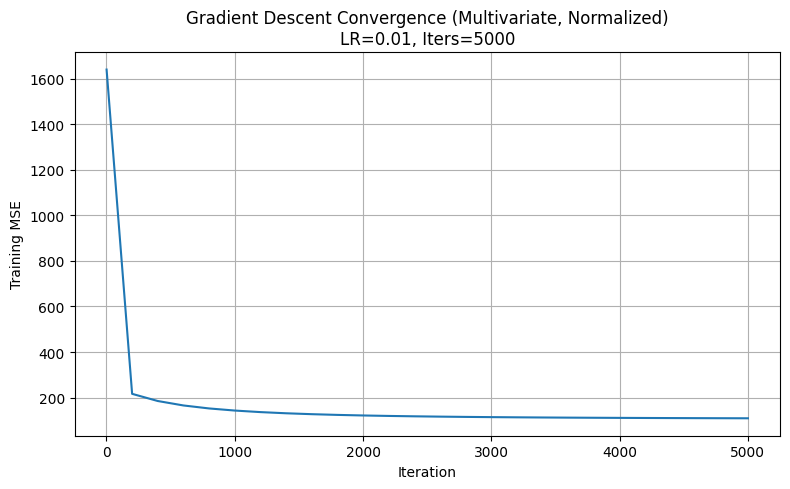

In [40]:
import matplotlib.pyplot as plt
   
 # Loss plot
losses_demo = multi_scaled.loc[0, "losses"]
iters_demo = int(multi_scaled.loc[0, "iters"])
record_every_demo = int(multi_scaled.loc[0, "record_every"])
lr_demo = multi_scaled.loc[0, "LR"]

x_iters = [1]
for t in range(record_every_demo, iters_demo + 1, record_every_demo):
    x_iters.append(t)
if x_iters[-1] != iters_demo:
    x_iters.append(iters_demo)
x_iters = x_iters[:len(losses_demo)]

plt.figure(figsize=(8, 5))
plt.plot(x_iters, losses_demo)
plt.xlabel("Iteration")
plt.ylabel("Training MSE")
plt.title(f"Gradient Descent Convergence (Multivariate, Normalized)\nLR={lr_demo}, Iters={iters_demo}")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Q2.1

In [41]:
alpha = 0.1
X = np.array([[3, 4, 5]], dtype=float) # shape (1,3)
y = np.array([4], dtype=float)

w0 = np.ones(3)
b0 = 1.0

w1, b1, _ = gradient_descent(X, y, lr=alpha, iters=1, record_every=None, w0=w0, b0=b0)

print("Q2.1")
print("New m1:", w1[0])
print("New m2:", w1[1])
print("New m3:", w1[2])
print("New b :", b1)

Q2.1
New m1: -4.4
New m2: -6.2
New m3: -8.0
New b : -0.8


#### Q2.2

In [42]:
alpha = 0.1
w0 = np.ones(3)
b0 = 1.0

X = np.array([
    [3, 4, 4],
    [4, 2, 1],
    [10, 2, 5],
    [3, 4, 5],
    [11, 1, 1],
], dtype=float)

y = np.array([3, 2, 8, 4, 5], dtype=float)

w, b, _ = gradient_descent(X, y, lr=alpha, iters=1, record_every=None, w0=w0, b0=b0)

print("Q2.2")
print("New m1:", w[0])
print("New m2:", w[1])
print("New m3:", w[2])
print("New b :", b)

print(w, b)

Q2.2
New m1: -10.080000000000002
New m2: -3.5200000000000005
New m3: -4.840000000000001
New b : -0.72
[-10.08  -3.52  -4.84] -0.72


## Part C

In [43]:
import statsmodels.api as sm

CSV_PATH = "Concrete_Data.csv" # In case run independently

def _add_intercept_df(X: np.ndarray, feature_cols: list[str]) -> pd.DataFrame:
    X_df = pd.DataFrame(np.asarray(X, dtype=float), columns=feature_cols)
    X_df = sm.add_constant(X_df, has_constant="add")
    X_df = X_df.rename(columns={"const": "Intercept"})
    return X_df

def fit_ols(X_train: np.ndarray, y_train: np.ndarray, feature_cols: list[str]):
    """
    y = b + Xw
    """
    X_design = _add_intercept_df(X_train, feature_cols)
    y = np.asarray(y_train, dtype=float).reshape(-1)
    return sm.OLS(y, X_design).fit()

def ols_predict(res, X: np.ndarray, feature_cols: list[str]) -> np.ndarray:
    X_design = _add_intercept_df(X, feature_cols)
    return np.asarray(res.predict(X_design), dtype=float)

def extract_pvalues(res, label: str) -> pd.DataFrame:

    return pd.DataFrame({
        "set": label,
        "term": res.params.index,
        "coef": res.params.values,
        "p_value": res.pvalues.values,
        "std_err": res.bse.values,
        "t_value": res.tvalues.values,
    })

def performance_row(label: str, y_train, yhat_train, y_test, yhat_test) -> dict:
    return {
        "set": label,
        "train_mse": mse(y_train, yhat_train),
        "train_r2": r2_variance(y_train, yhat_train),
        "test_mse": mse(y_test, yhat_test),
        "test_r2": r2_variance(y_test, yhat_test),
    }

#### Run everything

In [44]:
train_df, test_df = load_and_split(CSV_PATH)
X_train_raw, y_train, feature_cols, target_col = get_Xy(train_df)
X_test_raw, y_test, _, _ = get_Xy(test_df)

X_train_norm, X_test_norm = Normal_transform(X_train_raw, X_test_raw)
X_train_log = np.log1p(X_train_raw)
X_test_log = np.log1p(X_test_raw)

sets = {
    "Set2_Raw": (X_train_raw, X_test_raw),
    "Set1_MinMax": (X_train_norm, X_test_norm),
    "Set3_Log": (X_train_log, X_test_log),
}

p_tables = []
perf_rows = []

for label, (Xtr, Xte) in sets.items():
    res = fit_ols(Xtr, y_train, feature_cols)
    p_tables.append(extract_pvalues(res, label=label))

    yhat_tr = ols_predict(res, Xtr, feature_cols)
    yhat_te = ols_predict(res, Xte, feature_cols)
    perf_rows.append(performance_row(label, y_train, yhat_tr, y_test, yhat_te))

p_all = pd.concat(p_tables, ignore_index=True)
perf_df = pd.DataFrame(perf_rows)

p_all.to_csv("PartC_PValues_AllSets.csv", index=False)
perf_df.to_csv("PartC_Performance_AllSets.csv", index=False)

print("\nDone Saved")


Done Saved
